# Description

In this notebook, I will explore the **Flicker 8k** dataset.

In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from PIL import Image

from data_utils import *

/home/necphy/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Load dataset

In [2]:
PATH_FILE_CAPTION = 'data/captions.txt'
PATH_FOLDER_IMAGES = 'data/Images/'

In [3]:
df = pd.read_csv(PATH_FILE_CAPTION)
print("There are {} image to captions".format(len(df)))
df.head()

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Caption 1: Two little white dogs are playing in the snow .
Caption 2: Two little white dogs are playing outside in the snow .
Caption 3: Two white dogs are running alongside one another in snowy grass .
Caption 4: Two white dogs running in the snow .
Caption 5: Two white dogs run through a fiels with snow .


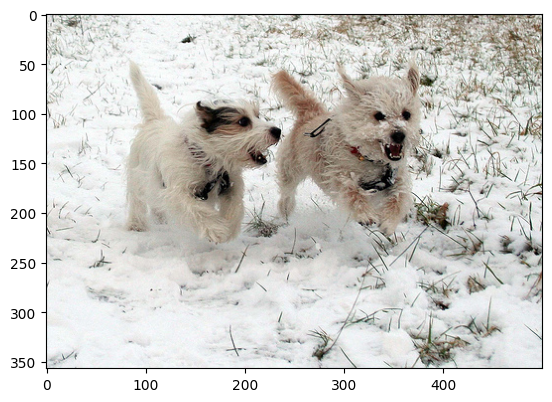

In [4]:
idx = np.random.randint(0, len(df)) // 5 * 5

img_name = df.loc[idx, 'image']

for i in range(5):
    print(f"Caption {i+1}: {df.loc[idx+i, 'caption']}")

img_path = os.path.join(PATH_FOLDER_IMAGES, img_name)
img = plt.imread(img_path)

plt.imshow(img);

# 2. Building vocabulary and Word tokenization

This section include:
- **Tokenization**: Break each text into smaller units, typically words or subwords.
- **Build Vocabulary**: Create a mapping from tokens to indices, assigning a unique integer to each token.
- **Numericalize Text**: Convert tokens into their corresponding indices for input to a model.

In [5]:
# Building the vocab
vocab = Vocabulary(freq_threshold=1)

vocab.build_vocab(df.caption.values)
print(f"Number of words in the vocab: {len(vocab)}")

Number of words in the vocab: 8922


In [6]:
test_sentence = "A person doing a trick on a rail while riding a skateboard."

print(f"Tokenized sentence: {vocab.tokenize(test_sentence)}")
print()
print(f"Numericalized sentence: {vocab.numericalize(test_sentence)}")

Tokenized sentence: ['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard.']

Numericalized sentence: [4, 191, 427, 4, 424, 41, 4, 418, 81, 650, 4, 3]


# 3. Writing the custom dataset

Writing the custom torch dataset class, therefore we can load the dataset during the training and validation process.

Specifically, dataloader is created which gives the batch of image and its captions with following processing done:
- Caption word tokenized to unique numbers
- vocab instance created to store all the relivent words in the datasets
- each batch, caption padded to have same sequence length
- image resized to the desired size.

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = FlickrDataset(df, vocab, path_folder_images=PATH_FOLDER_IMAGES, transform=transform)

In [ ]:
def display_random_image(dataset):
    """
    Display a random image from the dataset
    """
    idx = np.random.randint(0, len(dataset))
    img, caption = dataset[idx]
    print(f"Caption numerical: {caption}")
    print(f"Caption: {' '.join([dataset.vocab.int_2_str[i.item()] for i in caption])}")
    img = img.permute(1, 2, 0)
    plt.imshow(img);

Image shape: torch.Size([3, 224, 224])
Caption numerical: tensor([   1,    4,   43,   31,    9,   20,  196,    4, 1058,  126,   26, 2973,
          38,  134, 1850,   18,    2])
Caption: <SOS> a white dog is going for a walk through the desert with its owner . <EOS>


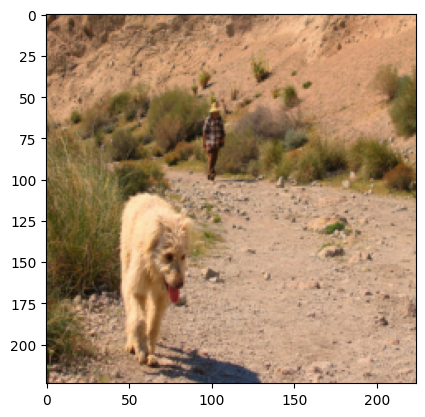

In [8]:
idx = np.random.randint(0, len(dataset))
img, caption = dataset[idx]
print(f"Image shape: {img.shape}")
print(f"Caption numerical: {caption}")
print(f"Caption: {' '.join([dataset.vocab.int_2_str[i.item()] for i in caption])}")

plt.imshow(img.permute(1, 2, 0));

## 3.2. Padding sequence

For each batch, caption padded to have same sequence length by add <PAD> into each sentence in the batch. 

We will do it by using the built-in `pad_sequence` and define the class `Collate`.

In [9]:
padding_value = dataset.vocab.str_2_int['<PAD>']

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, 
                        collate_fn=Collate(padding_value))

Images shape: torch.Size([2, 3, 224, 224])
Captions shape: torch.Size([2, 15])


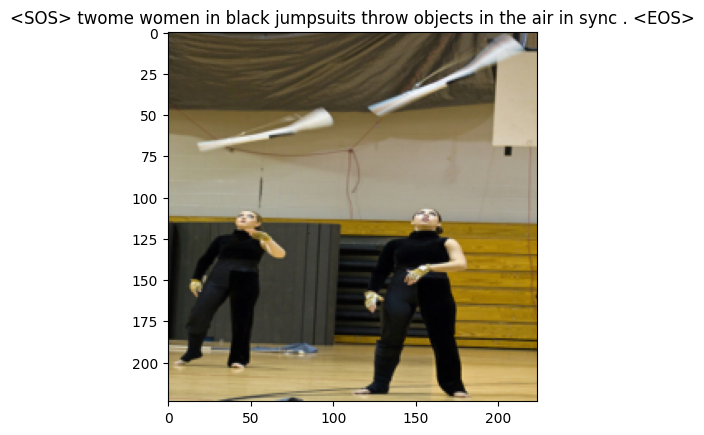

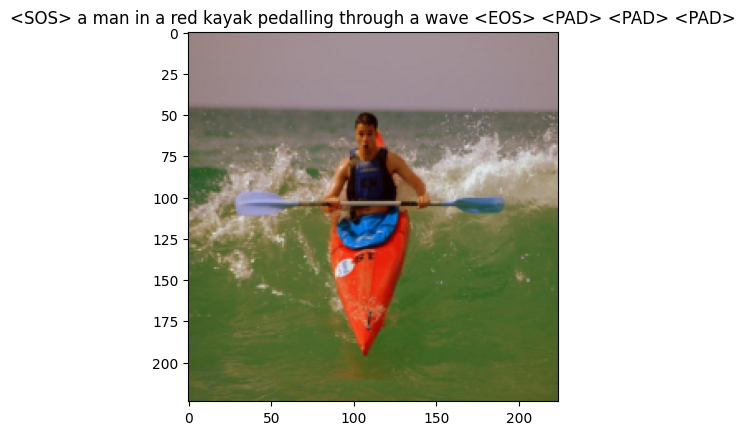

In [10]:
data_iter = iter(dataloader)
images, captions = next(data_iter)

print(f"Images shape: {images.shape}")
print(f"Captions shape: {captions.shape}")

for i in range(images.shape[0]):
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(' '.join([dataset.vocab.int_2_str[j.item()] for j in captions[i]]))
    plt.show()